<a href="https://colab.research.google.com/github/shdccywork/warehouse_forecast/blob/main/Warehouse_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes
----------------------
### Step 1-Data Cleansing Flow:
Read data>>>>Create a dataframe from all csv>>>mport Section Code>>>Data cleansing - Masking (not valid now)

Then

### Step 2-ML Flow:
Start from Read data to the end


### Other - create folders
1. Raw_data
2. Raw_data_masked
3. Section_code
4. Dataframe_ML
5. XGBoost_RMSE_R2
6. XGBoost_Acutal_vs_Prediction
7. Prediction_plot

# Read data

### Install darts

In [89]:
!pip install darts

### Import libraray

In [90]:
import pandas as pd
import os
import numpy as np
import holidays
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
# from statsmodels.tsa.arima.model import ARIMA
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from darts import TimeSeries
from sklearn.model_selection import TimeSeriesSplit # Cross Vildation particularly for Time series analysis, avoid leakage future information to the model.
from sklearn.model_selection import GridSearchCV
from tqdm import *
import matplotlib.dates as mdates


# Create folders

In [285]:
if os.path.exists('/content/Raw_data') == False:
    os.mkdir('/content/Raw_data')

# Change the current working directory
# os.chdir('/content/Raw_data')



In [286]:
if os.path.exists('/content/Raw_data_masked') == False:
  os.mkdir('/content/Raw_data_masked')

# Change the current working directory
os.chdir('/content/Raw_data_masked')

In [287]:
if os.path.exists('/content/Section_code') == False:
  os.mkdir('/content/Section_code')

# Change the current working directory
# os.chdir('/content/Section_code')

In [288]:
if os.path.exists('/content/Dataframe_ML') == False:
  os.mkdir('/content/Dataframe_ML')

# Change the current working directory
# os.chdir('/content/Dataframe_ML')

In [292]:
if os.path.exists('/content/Prediction_plot') == False:
  os.mkdir('/content/Prediction_plot')

# Change the current working directory
# os.chdir('/content/Prediction_plot')

In [290]:
if os.path.exists('/content/XGBoost_RMSE_R2') == False:
  os.mkdir('/content/XGBoost_RMSE_R2')

# Change the current working directory
# os.chdir('/content/XGBoost_RMSE_R2')

In [291]:
if os.path.exists('/content/XGBoost_Acutal_vs_Prediction') == False:
  os.mkdir('/content/XGBoost_Acutal_vs_Prediction')

# Change the current working directory
# os.chdir('/content/XGBoost_RMSE_R2')

# Data cleansing - Masking



In [98]:
# Read abive instruction before start"
directory_path = '/content/drive/MyDrive/Colab Notebooks/Raw_data' # /content/Raw_data_masked' or '/content/Raw_data'
csv_files = [ f for f in os.listdir(directory_path) if f.endswith('.csv')]
print(csv_files)

['Delivery Billing Summary-202406.csv', 'Delivery Billing Summary-202405_update.csv', 'Delivery Billing Summary-202404_R2.csv', 'Delivery Billing Summary-202402_Sheldon.csv', 'Delivery Billing Summary-202401_R2_Sheldon.csv', 'Delivery Billing Summary-202312.csv', 'Delivery Billing Summary-202311 R1.csv', 'Delivery Billing Summary-202310_R1.csv', 'Delivery Billing Summary-202309 Part 2-R4.csv', 'Delivery Billing Summary-202309 Part 1.csv']


### Append all data files

In [99]:
# create a dataframe

data_frames = []

# Loop through the CSV files and read each one into a DataFrame
for i, file in enumerate(csv_files):
    file_path = os.path.join(directory_path, file)  # Construct the full file path
    df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
    df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
    data_frames.append(df)  # Append the DataFrame to the list


df_combined = pd.concat(data_frames, ignore_index= True)
# df_combined['Delivery Date'] = pd.to_datetime(df_combined['Delivery Date'])
print(df_combined.dtypes)

Delivery Date                   datetime64[ns]
MDO #                                   object
DN# (Battery)                           object
Customer Code                           object
Address Code                            object
Customer Name                           object
District                                object
Address                                 object
Drop Point                              object
# of CTN                               float64
Delivery Charge                        float64
GW (Battery)                           float64
Gate Charges                            object
Tunnel Fee                              object
Doc Registration Fee                    object
Overtime hour                          float64
Others                                 float64
Remarks                                 object
Total Charge                           float64
CODE                                    object
Average Gate Charges                    object
Average Tunne

### Data Cleansing - Import Section code

In [100]:
# read section code

section_code_loc = '/content/drive/MyDrive/Colab Notebooks/Section_code/Section_code.csv'

section_code = pd.read_csv(section_code_loc)

print(section_code)

     Customer Code Customer_code_new Section_code_new
0            D3069             A3168            HK800
1            H0392              B493            HK800
2            K1689             C1782            HK800
3            M1016             D1485            HK800
4            Q0001              E244            AAA32
...            ...               ...              ...
4687         T1001             H1167            HK800
4688         T4001             H4383            HK800
4689         T4045             H4051            HK800
4690         Y0030              I245         HKF42100
4691         Y0035              I424            HK800

[4692 rows x 3 columns]


### Data Cleansing - merge with section code

In [101]:
# This code is applicable only if 'Customer Code' column in'section_code.csv'and csv in 'raw_data' folder


for i, file in enumerate(csv_files):
    csv_file_name = csv_files[i]
    file_path = os.path.join(directory_path,file)
    df = pd.read_csv(file_path)
    df_merge =pd.merge(df,section_code, left_on='Customer Code',right_on='Customer Code', how='left')
    print(df_merge.columns)
    # Carefully active the below 3 line2 to clean data, you need to choose "df_merge.drop()"or "df.drop", case dependent
    df_merge.drop(columns='Customer Code', inplace=True)
    df_merge.drop(columns=['Average Gate Charges','Average Tunnel Fee', 'Average Doc Registration Fee', 'Average Others'], inplace=True)
    df_merge.drop(columns=['Customer Name','District', 'Address Code','Drop Point'], inplace=True)

    #save to csv
    df_merge.to_csv(f'/content/Raw_data_masked/{csv_file_name}_masked.csv', index=False)


Index(['Delivery Date', 'MDO #', 'DN# (Battery)', 'Customer Code',
       'Address Code', 'Customer Name', 'District', 'Address', 'Drop Point',
       '# of CTN', 'Delivery Charge', 'GW (Battery)', 'Gate Charges',
       'Tunnel Fee', 'Doc Registration Fee', 'Overtime hour', 'Others',
       'Remarks', 'Total Charge', 'CODE', 'Average Gate Charges',
       'Average Tunnel Fee', 'Average Doc Registration Fee', 'Average Others',
       'Charter Truck Type', '# of Pallet', 'Customer_code_new',
       'Section_code_new'],
      dtype='object')
Index(['Delivery Date', 'MDO #', 'DN# (Battery)', 'Customer Code',
       'Address Code', 'Customer Name', 'District', 'Address', 'Drop Point',
       '# of CTN', 'Delivery Charge', 'GW (Battery)', 'Gate Charges',
       'Tunnel Fee', 'Doc Registration Fee', 'Overtime hour', 'Others',
       'Remarks', 'Total Charge', 'CODE', 'Average Gate Charges',
       'Average Tunnel Fee', 'Average Doc Registration Fee', 'Average Others',
       'Charter Truck T

### Create a dataframe from all csv

In [102]:
# Read raw data

'''change directory_path from '/content/Raw_data' to '/content/Raw_data_masked' after data is cleansed in Data cleansing - Masking Secton
Folder "Dataframe_ML" must be removed after data is cleansed '''

# Read abive instruction before start"
directory_path = '/content/drive/MyDrive/Colab Notebooks/Raw_data' # /content/Raw_data_masked' or '/content/Raw_data'
csv_files = [ f for f in os.listdir(directory_path) if f.endswith('.csv')]
print(csv_files)


['Delivery Billing Summary-202406.csv', 'Delivery Billing Summary-202405_update.csv', 'Delivery Billing Summary-202404_R2.csv', 'Delivery Billing Summary-202402_Sheldon.csv', 'Delivery Billing Summary-202401_R2_Sheldon.csv', 'Delivery Billing Summary-202312.csv', 'Delivery Billing Summary-202311 R1.csv', 'Delivery Billing Summary-202310_R1.csv', 'Delivery Billing Summary-202309 Part 2-R4.csv', 'Delivery Billing Summary-202309 Part 1.csv']


In [103]:
# create a dataframe

data_frames = []

# Loop through the CSV files and read each one into a DataFrame
for i, file in enumerate(csv_files):
    file_path = os.path.join(directory_path, file)  # Construct the full file path
    df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
    df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
    data_frames.append(df)  # Append the DataFrame to the list


df_combined = pd.concat(data_frames, ignore_index= True)
# df_combined['Delivery Date'] = pd.to_datetime(df_combined['Delivery Date'])
print(df_combined.dtypes)


Delivery Date                   datetime64[ns]
MDO #                                   object
DN# (Battery)                           object
Customer Code                           object
Address Code                            object
Customer Name                           object
District                                object
Address                                 object
Drop Point                              object
# of CTN                               float64
Delivery Charge                        float64
GW (Battery)                           float64
Gate Charges                            object
Tunnel Fee                              object
Doc Registration Fee                    object
Overtime hour                          float64
Others                                 float64
Remarks                                 object
Total Charge                           float64
CODE                                    object
Average Gate Charges                    object
Average Tunne

### Import Section Code

In [104]:
# read section code

section_code_loc = '/content/drive/MyDrive/Colab Notebooks/Section_code/Section_code.csv'

section_code = pd.read_csv(section_code_loc)

print(section_code)


     Customer Code Customer_code_new Section_code_new
0            D3069             A3168            HK800
1            H0392              B493            HK800
2            K1689             C1782            HK800
3            M1016             D1485            HK800
4            Q0001              E244            AAA32
...            ...               ...              ...
4687         T1001             H1167            HK800
4688         T4001             H4383            HK800
4689         T4045             H4051            HK800
4690         Y0030              I245         HKF42100
4691         Y0035              I424            HK800

[4692 rows x 3 columns]


# After data cleansing


In [105]:

# Check columns
print("Dtypes:",df_combined.dtypes)
print("----------------------------")
df_combined.dropna(subset='Delivery Date', inplace=True)

# print("Sort_values:",df_combined.sort_values(by='Delivery Date'))
# print("----------------------------")
# df_combined.to_csv('/content/df_combined.csv')



Dtypes: Delivery Date                   datetime64[ns]
MDO #                                   object
DN# (Battery)                           object
Customer Code                           object
Address Code                            object
Customer Name                           object
District                                object
Address                                 object
Drop Point                              object
# of CTN                               float64
Delivery Charge                        float64
GW (Battery)                           float64
Gate Charges                            object
Tunnel Fee                              object
Doc Registration Fee                    object
Overtime hour                          float64
Others                                 float64
Remarks                                 object
Total Charge                           float64
CODE                                    object
Average Gate Charges                    object
Avera

# **Create a Dataframe for ML**

7 datadrames will be created with different features
the creation of each dataframe is dependent to the dataframe in the previous steps

The name of each dataframe tells what the features have been added to the dataframe


1. df_warehouse
2. df_warehouse_date_range
3. df_warehouse_date_range_YMD
4. df_warehouse_date_range_YMD_holidays
5. df_warehouse_date_range_YMD_holidays_lags
6. df_warehouse_date_range_YMD_holidays_lags_seasonal
7. df_warehouse_date_range_YMD_holidays_lags_seasonal_trend

## 1. Delivery Date vs. # of CTN

In [106]:
# Rename the dataframe
df_combined.rename(columns = {'Delivery Date':'date'}, inplace=True)

# Create df_warehouse
df_warehouse = df_combined.groupby('date').agg({'# of CTN':'sum'},observed=False)
df_warehouse.head()


,# of CTN
date,
2023-08-21,1491.0
2023-08-22,1167.0
2023-08-23,1609.0
2023-08-24,1787.0
2023-08-25,992.0


1.5 . Add fearure : Date range

In [107]:
df_combined.rename(columns=({'Delivery Date':'date'}), inplace=True)
start_date = df_combined['date'].min()
end_date = df_combined['date'].max()


#Create a full date range
df_full_date_range = pd.date_range(start= start_date, end= end_date, freq='D') # dtype='datetime64[ns]
df_full_date_range

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30',
               ...
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
               '2024-06-19', '2024-06-20'],
              dtype='datetime64[ns]', length=305, freq='D')

In [108]:
df_warehouse_date_range= pd.merge(df_full_date_range.to_frame(name='date'), df_warehouse, left_index=True, right_index=True, how='left')
df_warehouse_date_range.fillna(0, inplace=True)
df_warehouse_date_range.head(30)



,date,# of CTN
2023-08-21,2023-08-21,1491.0
2023-08-22,2023-08-22,1167.0
2023-08-23,2023-08-23,1609.0
2023-08-24,2023-08-24,1787.0
2023-08-25,2023-08-25,992.0
2023-08-26,2023-08-26,995.0
2023-08-27,2023-08-27,0.0
2023-08-28,2023-08-28,873.0
2023-08-29,2023-08-29,1317.0
2023-08-30,2023-08-30,1128.0


## 2. Create a time sereis for ML with a lag of 7 days

A time line dataframe will be created based on the date range in df_combined


---


A lag of 7 days is created for XGboost
1. Otherwise, this dataframe cannot be used for prediction
2. To compare the forecasting result between Lag 7 and Lag 1 - 7


In [109]:

# creata a lag 7
# lag 7 is created for XGboost,
# 1) Otherwise, this dataframe cannot be used for prediction
# 2) To compare the forecasting result between Lag 7 and Lag 1 - 7
df_warehouse_date_range['Lag_7'] = df_warehouse_date_range['# of CTN'].shift(7)


# fill na to date which has no outbound volume as the warehouse operations stops on that date
df_warehouse_date_range.fillna(0, inplace = True)

# save dataframe
df_warehouse_date_range.to_csv('/content/Dataframe_ML/df_warehouse_date_range.csv', index=False)
df_warehouse_date_range



,date,# of CTN,Lag_7
2023-08-21,2023-08-21,1491.0,0.0
2023-08-22,2023-08-22,1167.0,0.0
2023-08-23,2023-08-23,1609.0,0.0
2023-08-24,2023-08-24,1787.0,0.0
2023-08-25,2023-08-25,992.0,0.0
...,...,...,...
2024-06-16,2024-06-16,0.0,0.0
2024-06-17,2024-06-17,1519.0,0.0
2024-06-18,2024-06-18,2231.0,2633.0
2024-06-19,2024-06-19,1701.0,2322.0


## 3. Add fearure : year, month, day, day ofweek

In [110]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

#drop lag 7
df_warehouse_date_range.drop(columns ='Lag_7', inplace=True)


df_warehsoue_date_range_YMD = df_warehouse_date_range.copy()

year = datetime_attribute_timeseries(time_index = df_full_date_range, attribute='year')
month = datetime_attribute_timeseries(time_index= df_full_date_range, attribute='month')
day = datetime_attribute_timeseries(time_index = df_full_date_range, attribute='day')
dayofyear = datetime_attribute_timeseries(time_index = df_full_date_range, attribute = 'dayofyear')
weekday = datetime_attribute_timeseries(time_index = df_full_date_range , attribute='dayofweek')
weekofyear = datetime_attribute_timeseries(time_index = df_full_date_range, attribute='weekofyear')

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear)
time_cov = time_cov.pd_dataframe()
time_cov.index

# Merge time_cov and df_warehsoue_date_range_YMD
df_warehsoue_date_range_time_feature = pd.merge(time_cov, df_warehsoue_date_range_YMD, left_index=True,right_index=True, how='left')

# save to csv
df_warehsoue_date_range_time_feature.to_csv('/content/Dataframe_ML/df_warehouse_date_range_time_feature.csv', index=False)



## 4.Add fearures: hk_holidays

In [111]:
#retreive hong Kogn holidays
hk_holidays = holidays.HongKong()

# copy the df_warehsoue_timeline and create df_warehouse_timeline_holidays for adding HK holiday
df_warehsoue_date_range_time_feature_holidays = df_warehsoue_date_range_time_feature.copy()


# Create holiday appneded dataframe
df_warehsoue_date_range_time_feature_holidays['is_hk_holiday'] = df_warehsoue_date_range_time_feature_holidays['date'].apply(lambda x : x in hk_holidays) *1

# save df_warehouse_holidays
df_warehsoue_date_range_time_feature_holidays.to_csv('/content/Dataframe_ML/df_warehsoue_date_range_time_feature_holidays.csv', index=False)

df_warehsoue_date_range_time_feature_holidays

,year,month,day,dayofyear,dayofweek,weekofyear,date,# of CTN,is_hk_holiday
time,,,,,,,,,
2023-08-21,2023.0,7.0,20.0,232.0,0.0,33.0,2023-08-21,1491.0,0
2023-08-22,2023.0,7.0,21.0,233.0,1.0,33.0,2023-08-22,1167.0,0
2023-08-23,2023.0,7.0,22.0,234.0,2.0,33.0,2023-08-23,1609.0,0
2023-08-24,2023.0,7.0,23.0,235.0,3.0,33.0,2023-08-24,1787.0,0
2023-08-25,2023.0,7.0,24.0,236.0,4.0,33.0,2023-08-25,992.0,0
...,...,...,...,...,...,...,...,...,...
2024-06-16,2024.0,5.0,15.0,167.0,6.0,23.0,2024-06-16,0.0,0
2024-06-17,2024.0,5.0,16.0,168.0,0.0,24.0,2024-06-17,1519.0,0
2024-06-18,2024.0,5.0,17.0,169.0,1.0,24.0,2024-06-18,2231.0,0


## 5. Add features: lags ( to df_warehouse_holidays)

In [112]:
# create lags
max_lag = 7 # we could try 7 14 21 28 and check rmse and r2 for the best lag result
df_warehsoue_date_range_time_feature_holidays_lags = df_warehsoue_date_range_time_feature_holidays.copy()

for lag in range(1, max_lag+1):
    print('lag_:',lag)
    df_warehsoue_date_range_time_feature_holidays_lags [f'lag_{lag}'] = df_warehsoue_date_range_time_feature_holidays_lags['# of CTN'].shift(lag)
    df_warehsoue_date_range_time_feature_holidays_lags [f'lag_{lag}'].fillna(0, inplace = True)

df_warehsoue_date_range_time_feature_holidays_lags.to_csv('/content/Dataframe_ML/df_warehsoue_date_range_time_feature_holidays_lags.csv', index=False)
print(df_warehsoue_date_range_time_feature_holidays_lags.head(30))


lag_: 1
lag_: 2
lag_: 3
lag_: 4
lag_: 5
lag_: 6
lag_: 7
              year  month   day  dayofyear  dayofweek  weekofyear       date  \
time                                                                           
2023-08-21  2023.0    7.0  20.0      232.0        0.0        33.0 2023-08-21   
2023-08-22  2023.0    7.0  21.0      233.0        1.0        33.0 2023-08-22   
2023-08-23  2023.0    7.0  22.0      234.0        2.0        33.0 2023-08-23   
2023-08-24  2023.0    7.0  23.0      235.0        3.0        33.0 2023-08-24   
2023-08-25  2023.0    7.0  24.0      236.0        4.0        33.0 2023-08-25   
2023-08-26  2023.0    7.0  25.0      237.0        5.0        33.0 2023-08-26   
2023-08-27  2023.0    7.0  26.0      238.0        6.0        33.0 2023-08-27   
2023-08-28  2023.0    7.0  27.0      239.0        0.0        34.0 2023-08-28   
2023-08-29  2023.0    7.0  28.0      240.0        1.0        34.0 2023-08-29   
2023-08-30  2023.0    7.0  29.0      241.0        2.0        34.

<ipython-input-112-52661707ba03>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_warehsoue_date_range_time_feature_holidays_lags [f'lag_{lag}'].fillna(0, inplace = True)
<ipython-input-112-52661707ba03>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

## 6.Linear conbination - seaonal

In [137]:
# Seasonal decomposition and set additive mode
result = seasonal_decompose(df_warehsoue_date_range_time_feature_holidays_lags['# of CTN'], model='additive')


# Add the seasonal decomposed result into a DataFrame , only seasonal data is needed
decomposed_df_seasonal = pd.DataFrame({
    # 'Trend': result.trend,
    'Seasonal': result.seasonal,
    # 'Residual': result.resid # we dun need residual in dataframe for forecasting
})

# fillna to NaN data in Seasonal
decomposed_df_seasonal.fillna(0)
# Create seasonal decompose df with seasonal
df_warehsoue_date_range_time_feature_holidays_lags_seasonal = pd.merge(df_warehsoue_date_range_time_feature_holidays_lags,decomposed_df_seasonal, left_index=True, right_index= True, how = 'left')
df_warehsoue_date_range_time_feature_holidays_lags_seasonal.to_csv('/content/Dataframe_ML/df_warehsoue_date_range_time_feature_holidays_lags_seasonal.csv')
df_warehsoue_date_range_time_feature_holidays_lags_seasonal


DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30',
               ...
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
               '2024-06-19', '2024-06-20'],
              dtype='datetime64[ns]', name='time', length=305, freq='D')

## 7.Linear conbination - trend

In [138]:

# Create seasonal decompose df with seasonal and trend
decomposed_df_seasonal_trend = pd.DataFrame({
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    # 'Residual': result.resid # we dun need residual in dataframe for forecasting
})

# fillna to NaN data in Seasonal and trend
decomposed_df_seasonal_trend.fillna(0, inplace=True)


df_warehsoue_date_range_time_feature_holidays_lags_seasonal_trend = pd.merge(df_warehsoue_date_range_time_feature_holidays_lags,decomposed_df_seasonal_trend, left_index=True, right_index= True, how = 'left')
df_warehsoue_date_range_time_feature_holidays_lags_seasonal_trend.to_csv('/content/Dataframe_ML/df_warehsoue_date_range_time_feature_holidays_lags_seasonal_trend.csv')
df_warehsoue_date_range_time_feature_holidays_lags_seasonal_trend

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30',
               ...
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
               '2024-06-19', '2024-06-20'],
              dtype='datetime64[ns]', name='time', length=305, freq='D')

### Timeseries relaetd testing

1. ADF
2. ACF
3. PACF

#Statsitical

# ADF


In [115]:
adf_result = adfuller(df_warehouse_date_range['# of CTN'], autolag = 'AIC', maxlag= 21)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Number of lags used:', adf_result[2])
print('Number of observations used:', adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'  {key}: {value}')

if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary; differencing may be needed.")

ADF Statistic: -2.605545292379575
p-value: 0.09185657596747338
Number of lags used: 15
Number of observations used: 289
Critical Values:
  1%: -3.4531816058796143
  5%: -2.871593390724642
  10%: -2.5721268156511536
The time series is non-stationary; differencing may be needed.


# ACF

ACF values: [ 1.          0.41734994 -0.00390232 -0.1153768  -0.15035255 -0.05744675
  0.28985636  0.53887041  0.27076945 -0.07234521 -0.21665077 -0.17889429
 -0.08538974  0.23091305  0.53037981]


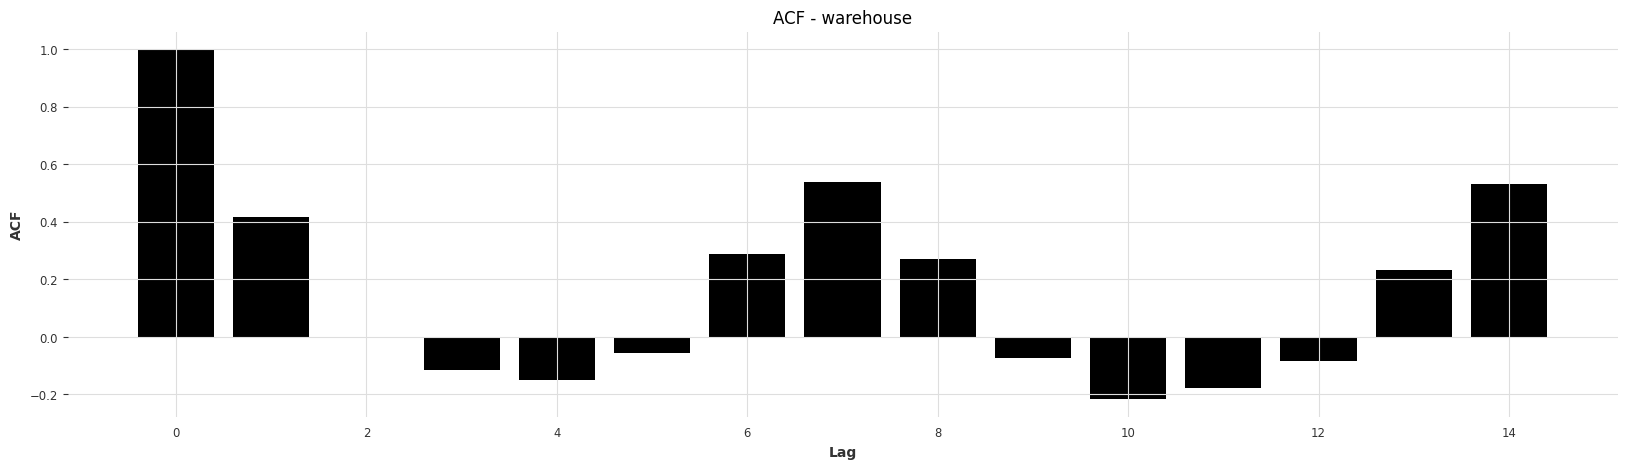

In [116]:
acf_lags = 14
acf_values = acf(df_warehouse_date_range['# of CTN'], nlags= acf_lags)
plt.figure(figsize=(20,5))
plt.bar(range(len(acf_values)), acf_values)
plt.title("ACF - warehouse")
plt.xlabel("Lag")
plt.ylabel("ACF")
print('ACF values:',acf_values)
# ACF_path = os.path.abspath('/Users/sheldon/Desktop/Data Project/Data Project outbound volume forecast/ACF')
# ACF_file_ = 'ACF-warehouse'
# plt.savefig(os.path.join(ACF_path,ACF_file_),bbox_inches='tight') # Use bbox_inches='tight' to fit the figure nicely


# PCAF

PACF values: [ 1.          0.4187228  -0.21736767 -0.02991426 -0.10443276  0.0458432
  0.35509203  0.36191674 -0.0797445  -0.14912923 -0.1107074   0.04509328
 -0.03843768  0.13394819  0.29831556]


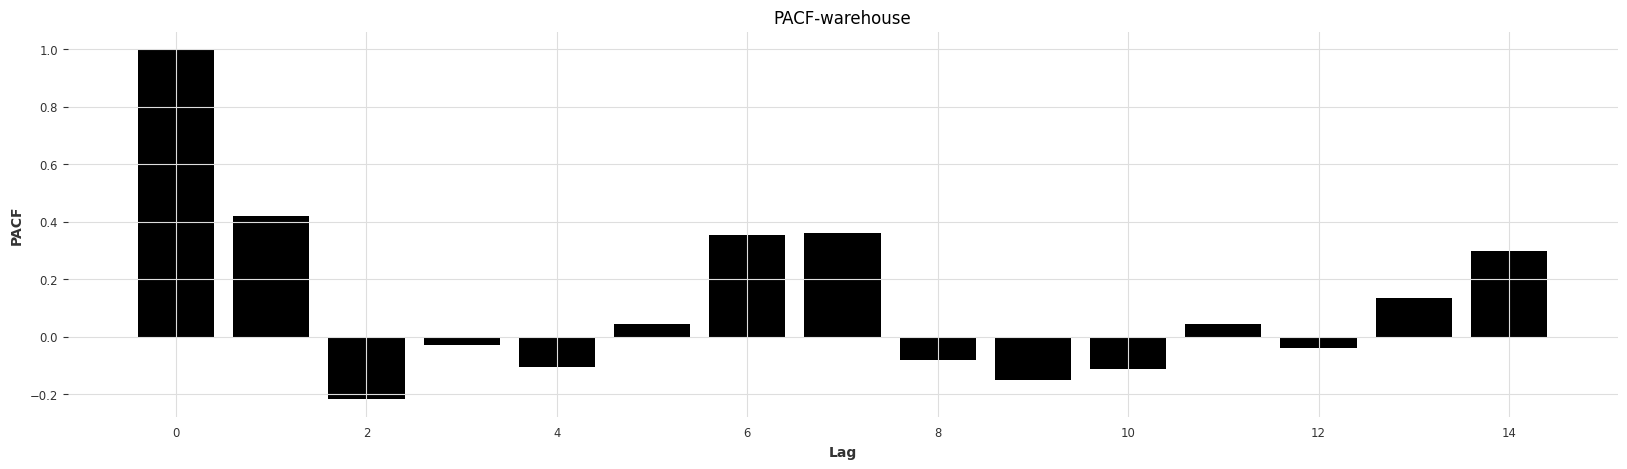

In [117]:
pacf_nlags = 14
pacf_values = pacf(df_warehouse_date_range['# of CTN'], nlags= pacf_nlags)
plt.figure(figsize=(20,5))
plt.bar(range(len(pacf_values)), pacf_values)
plt.title("PACF-warehouse")
plt.xlabel('Lag')
plt.ylabel('PACF')

# save the PACF result
# PACF_path = os.path.abspath('/Users/sheldon/Desktop/Data Project/Data Project outbound volume forecast/PACF')
# PACF_file_ = 'PACF-warehouse'
# plt.savefig(os.path.join(PACF_path,PACF_file_),bbox_inches='tight') # Use bbox_inches='tight' to fit the figure nicely
print('PACF values:',pacf_values)

#Machine Learning

# Machine Learning - XGBoost - For loop

### XGBoost - For loop

['df_warehsoue_date_range_time_feature_holidays.csv', 'df_warehouse_date_range.csv', 'df_warehouse_date_range_time_feature.csv', 'df_warehsoue_date_range_time_feature_holidays_lags_seasonal_trend.csv', 'df_warehsoue_date_range_time_feature_holidays_lags.csv', 'df_warehsoue_date_range_time_feature_holidays_lags_seasonal.csv']
-----------------------------------------------------------------------------------------------------------------
df_warehsoue_date_range_time_feature_holidays.csv
-----------------------------------------------------------------------------------------------------------------
        date  Actual  Prediction  \
0 2024-06-14  2775.0      1537.0   
1 2024-06-15    75.0       145.0   
2 2024-06-16     0.0        44.0   
3 2024-06-17  1519.0      1700.0   
4 2024-06-18  2231.0      1803.0   
5 2024-06-19  1701.0      1978.0   
6 2024-06-20  2502.0      2217.0   

                                               df_ML  
0  df_warehsoue_date_range_time_feature_holidays.cs

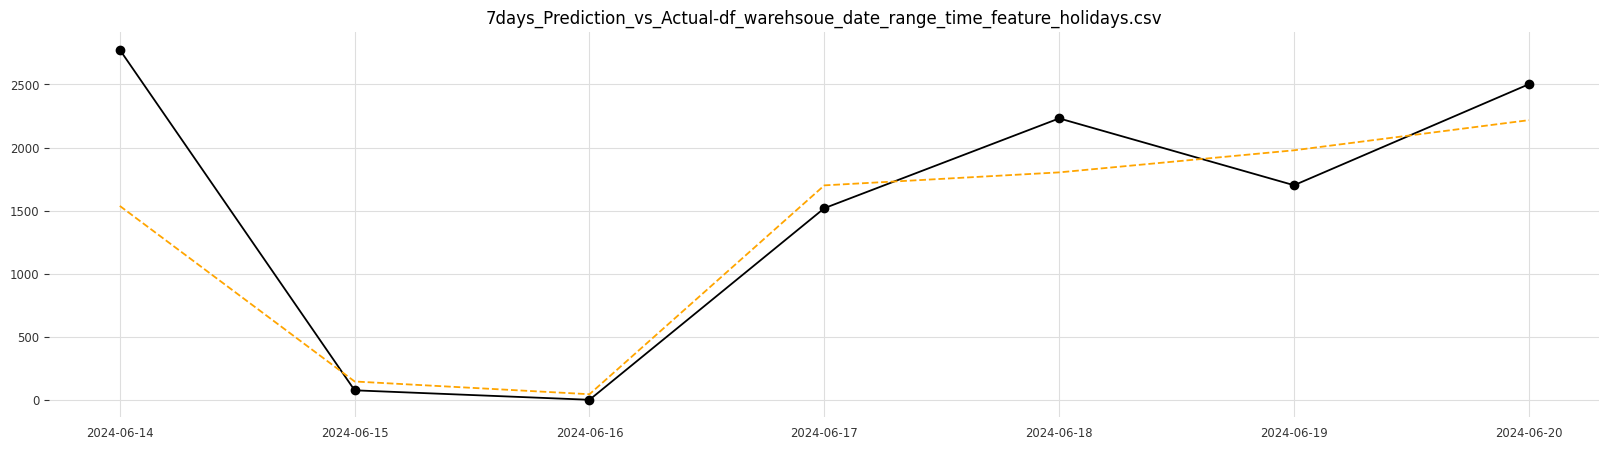

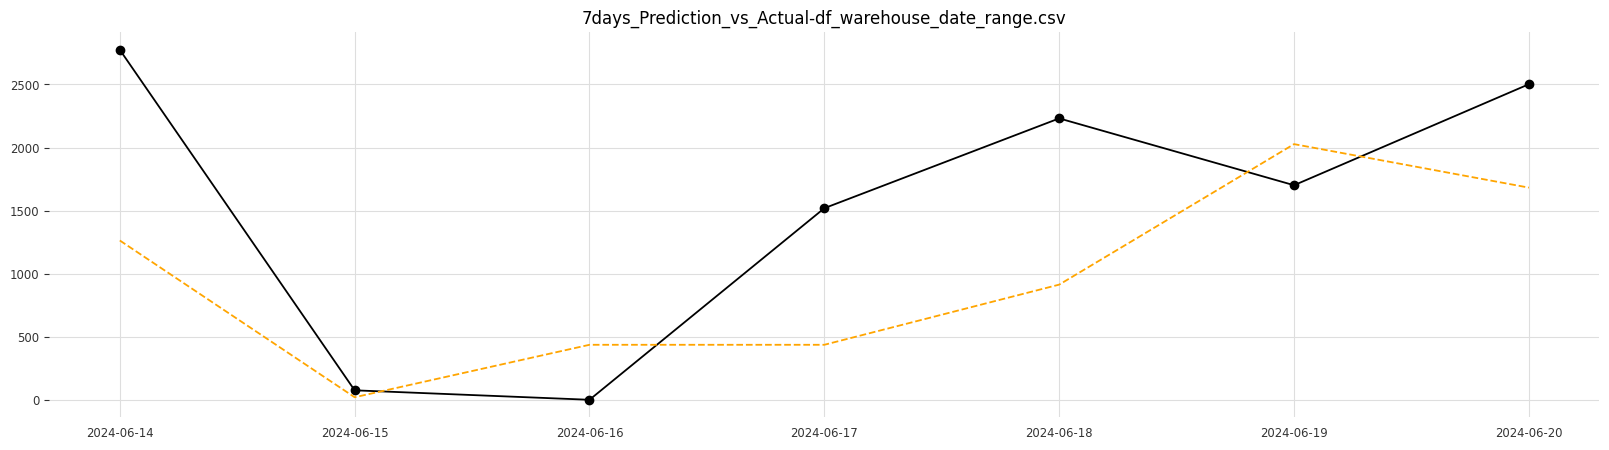

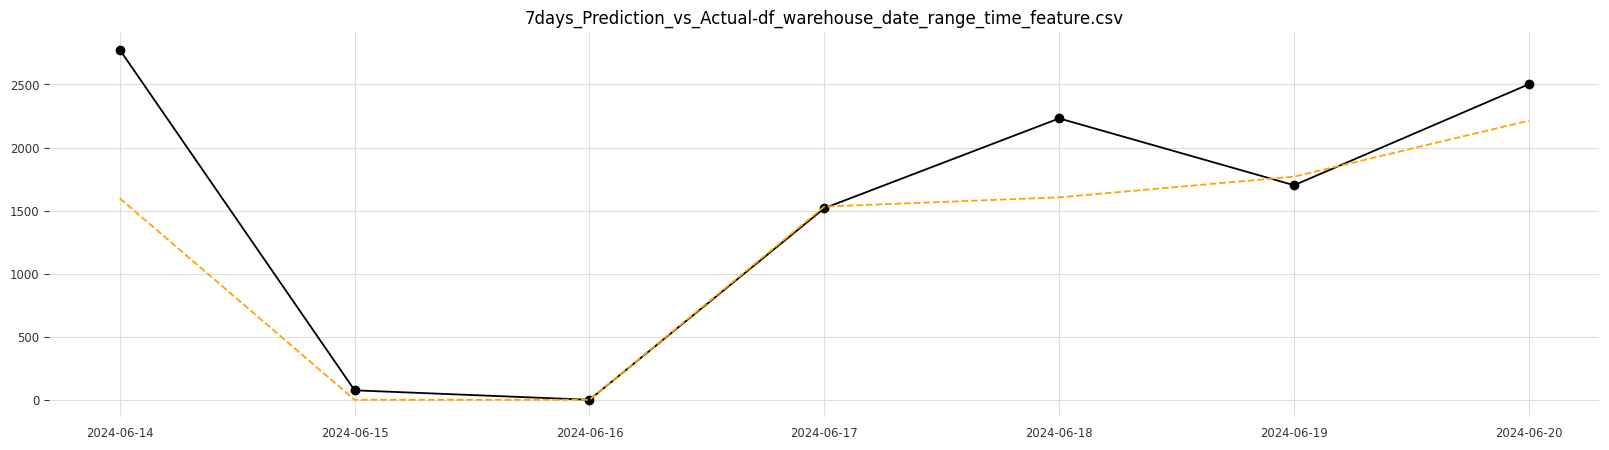

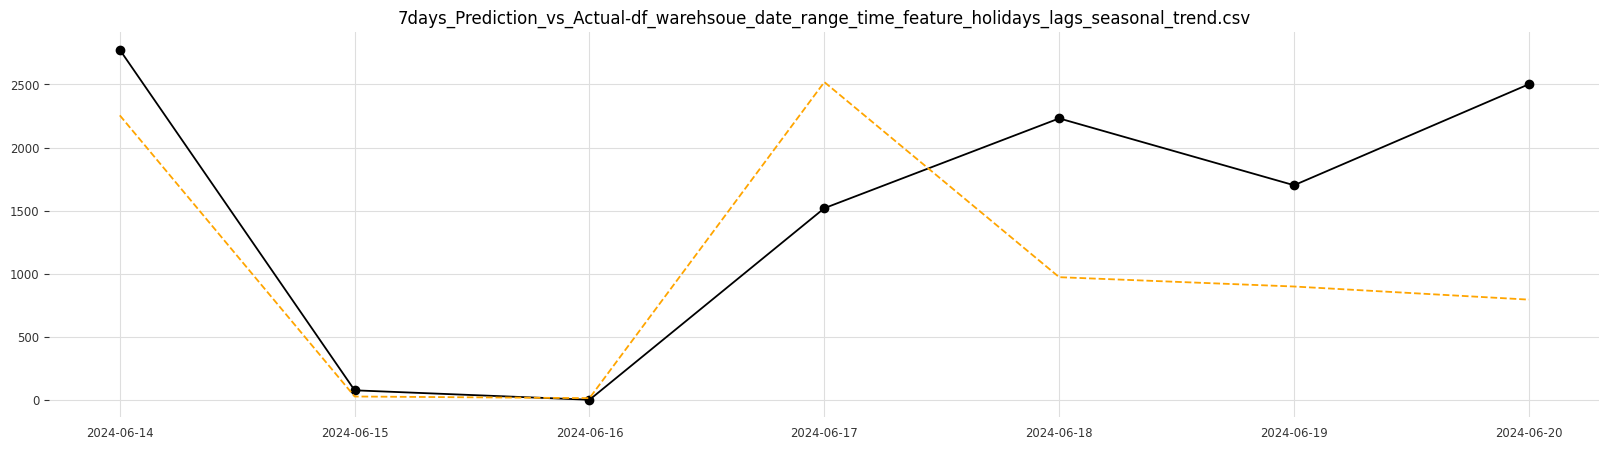

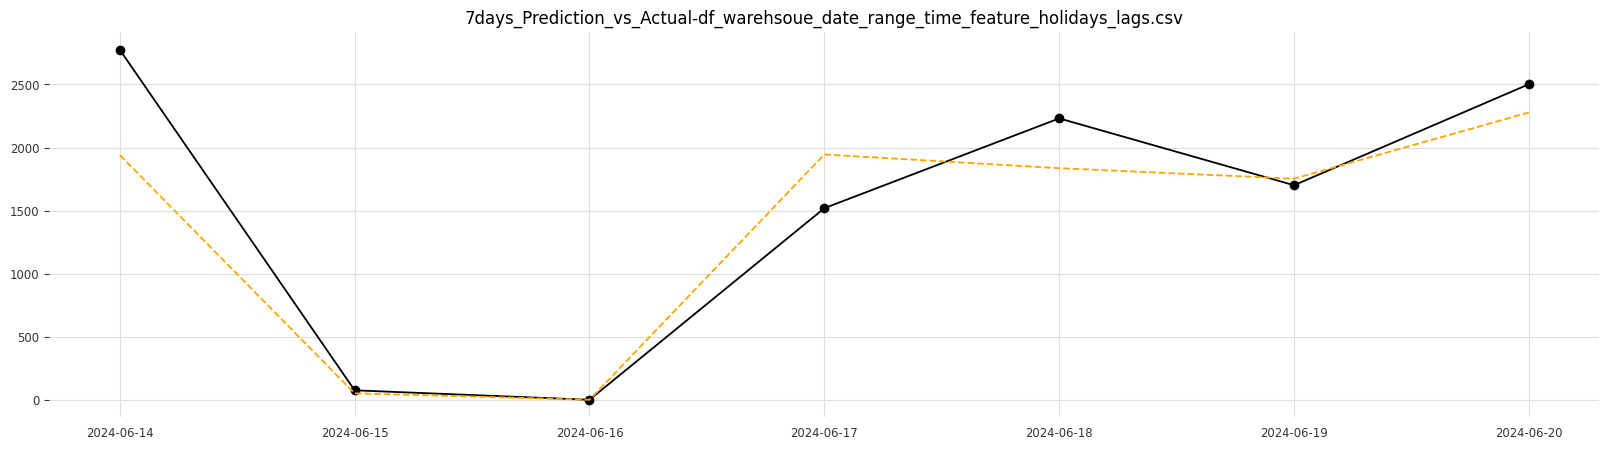

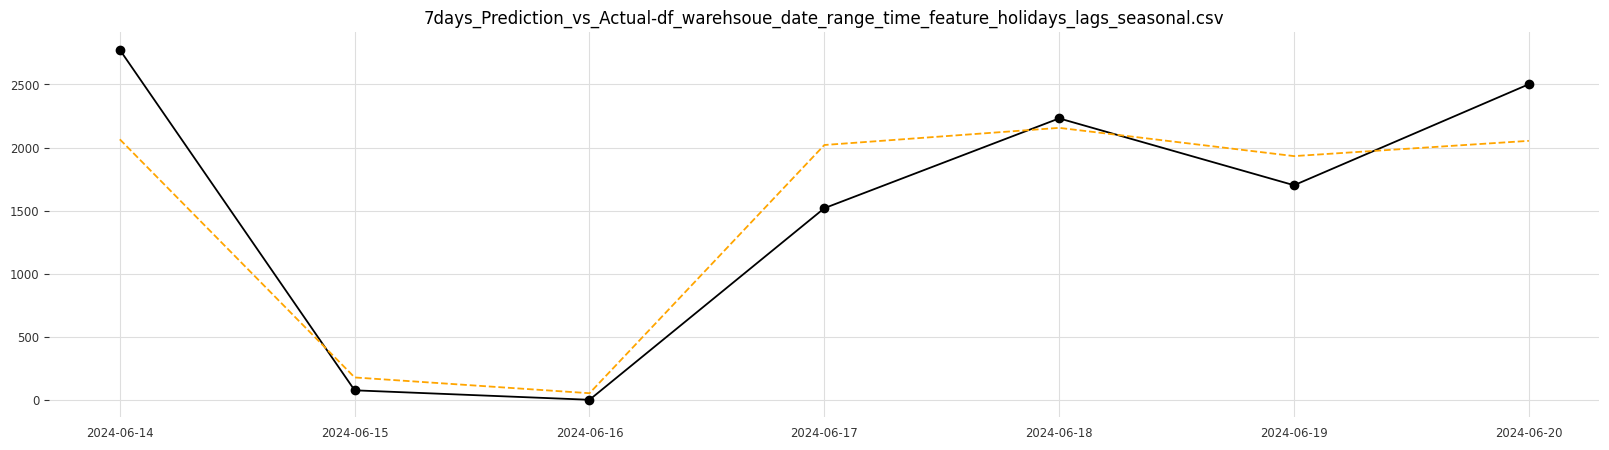

In [254]:
df_ML_dir = '/content/Dataframe_ML'
df_ML_csv = [f for f in os.listdir(df_ML_dir) if f.endswith('.csv')]
print(df_ML_csv)


row_rmse_r2 = []
df_y_test = []
df_actual_prediction = []


# define the mumber of testing days and trainig days
df_test_size = 7 #number_of_testing_days
df_train_size = len(df_ML) - df_test_size #number_of_training_days

for i, file in enumerate(df_ML_csv):
  print('-----------------------------------------------------------------------------------------------------------------')
  print(file)
  print('-----------------------------------------------------------------------------------------------------------------')
  file_path= os.path.join(df_ML_dir,file)
  df_ML = pd.read_csv(file_path)

  date_rng = pd.date_range(start=df_ML['date'].min(), periods=len(df_ML), freq='D')
  df_ML.index = date_rng


  # drop column 'time'
  if 'time' in df_ML.columns:
      df_ML.drop(columns='time', inplace=True)

  # drop column 'date'
  df_ML.drop(columns='date', inplace=True)

  # Create train and test dataset for training
  df_ML_train = df_ML.drop(columns='# of CTN')
  df_ML_test = df_ML['# of CTN']


  # Train-test split based on particular date range
  X_train, X_test = df_ML_train.iloc[:df_train_size], df_ML_train.iloc[-df_test_size :]
  y_train, y_test = df_ML_test.iloc[:df_train_size], df_ML_test.iloc[-df_test_size :]

  model = xgboost.XGBRegressor()

  # training
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  mse = mean_squared_error(y_test, prediction)
  rmse = np.sqrt(mse)
  r_square = r2_score(y_test, prediction)
  # print(f'{i}_rmse:', rmse)
  # print(f'{i}_R2:', r_square)


  row_rmse_r2.append({
      'df_ML':file,
      'RMSE': np.round(rmse, 3),
      'R²': np.round(r_square, 3)
  })


  # Prediction ############################################################################################################################################

  # Actual
  df_y_test= pd.DataFrame({
        'date': y_test.index,
        'Actual': y_test
    })


  # Prediction - if # of CTN < 0, then 0, because # of CTN cannot be less than 0
  df_pred_data = pd.DataFrame({
        'date': y_test.index,
        'Prediction':[np.round(pred,0) if pred >= 0 else 0 for pred in prediction]
    })

  df_pred_data['date'] = pd.to_datetime(df_pred_data['date'])


  #merge actual and precdiction
  df_ML_prediction = pd.merge(df_y_test, df_pred_data, on='date', how='left')

  df_ML_prediction['df_ML'] = file
  print(df_ML_prediction)

  # save actual and precdiction data into a dataframe
  df_ML_prediction.to_csv(f'/content/XGBoost_Acutal_vs_Prediction/XGBoost_Acutal_vs_Prediction_{file}.csv')

  # End of a loop ############################################################################################################################################

  # plot
  plt.figure(figsize=(20,5))

  plt.plot(df_ML_prediction['date'],df_ML_prediction['Actual'], label = 'Actual', marker = 'o')
  plt.plot(df_ML_prediction['date'],df_ML_prediction['Prediction'], label = f'Prediction{file}', linestyle='--', color='orange')
  plt.title(f'7days_Prediction_vs_Actual-{file}')

  df_actual_prediction.append(df_ML_prediction)




############################################################################################################################################



### RMSE and R-square of each dataframe


In [297]:
# rmse_r2 result


df_row_rmse_r2 = pd.DataFrame(row_rmse_r2)
df_row_rmse_r2.to_csv('/content/XGBoost_RMSE_R2/df_ML_row_rmse_r2.csv')

print(df_row_rmse_r2)


                                               df_ML     RMSE     R²
0  df_warehsoue_date_range_time_feature_holidays.csv  522.756  0.744
1                        df_warehouse_date_range.csv  938.704  0.175
2           df_warehouse_date_range_time_feature.csv  521.117  0.746
3  df_warehsoue_date_range_time_feature_holidays_...  957.506  0.141
4  df_warehsoue_date_range_time_feature_holidays_...  394.714  0.854
5  df_warehsoue_date_range_time_feature_holidays_...  383.298  0.862


# Visualizing all predictons and actuals (7 Days only) in one figure

df_warehsoue_date_range_time_feature_holidays.csv


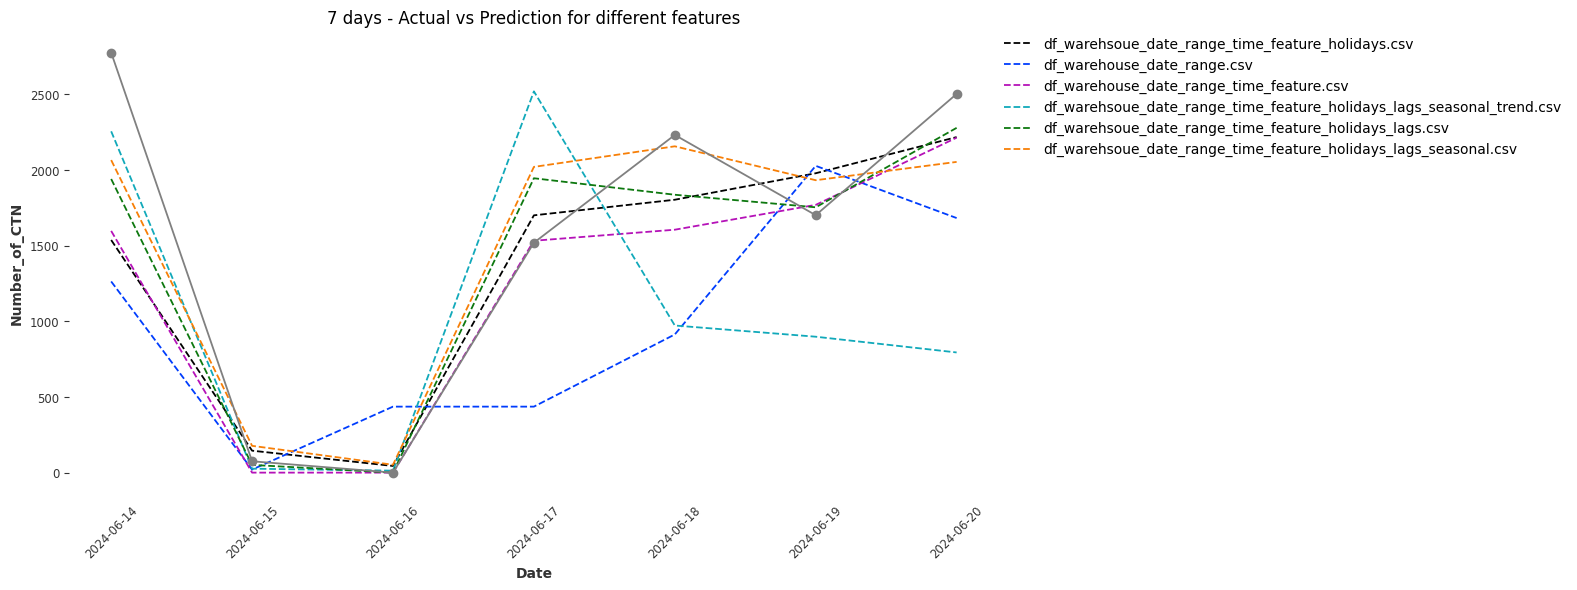

In [278]:
# Combine all predictions into a single DataFrame
combined_predictions = pd.concat(df_actual_prediction)


df_ML = combined_predictions['df_ML'].unique()
df_ML_1st = df_ML[0]
print(df_ML_1st)

plt.figure(figsize=(12, 6))

for df in df_ML:
  x = combined_predictions[combined_predictions['df_ML'] == df]['date']
  y = combined_predictions[combined_predictions['df_ML'] == df]['Prediction']

  plt.plot(x,y,linestyle='--', label=f'{df}')

x_actual = combined_predictions[combined_predictions['df_ML'] == df_ML_1st]['date']
y_actual = combined_predictions[combined_predictions['df_ML'] == df_ML_1st]['Actual']

plt.plot(x_actual,y_actual, marker='o', color='grey')


plt.title('7 days - Actual vs Prediction for different features')
plt.xlabel('Date')
plt.ylabel('Number_of_CTN')
plt.xticks(rotation=45)

# Place the legend outside the plot on the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)

plt.grid()

# Visulaizing all predictions

                 date  Actual                    df_ML
2023-08-21 2023-08-21  1491.0  df_warehouse_date_range
2023-08-22 2023-08-22  1167.0  df_warehouse_date_range
2023-08-23 2023-08-23  1609.0  df_warehouse_date_range
2023-08-24 2023-08-24  1787.0  df_warehouse_date_range
2023-08-25 2023-08-25   992.0  df_warehouse_date_range


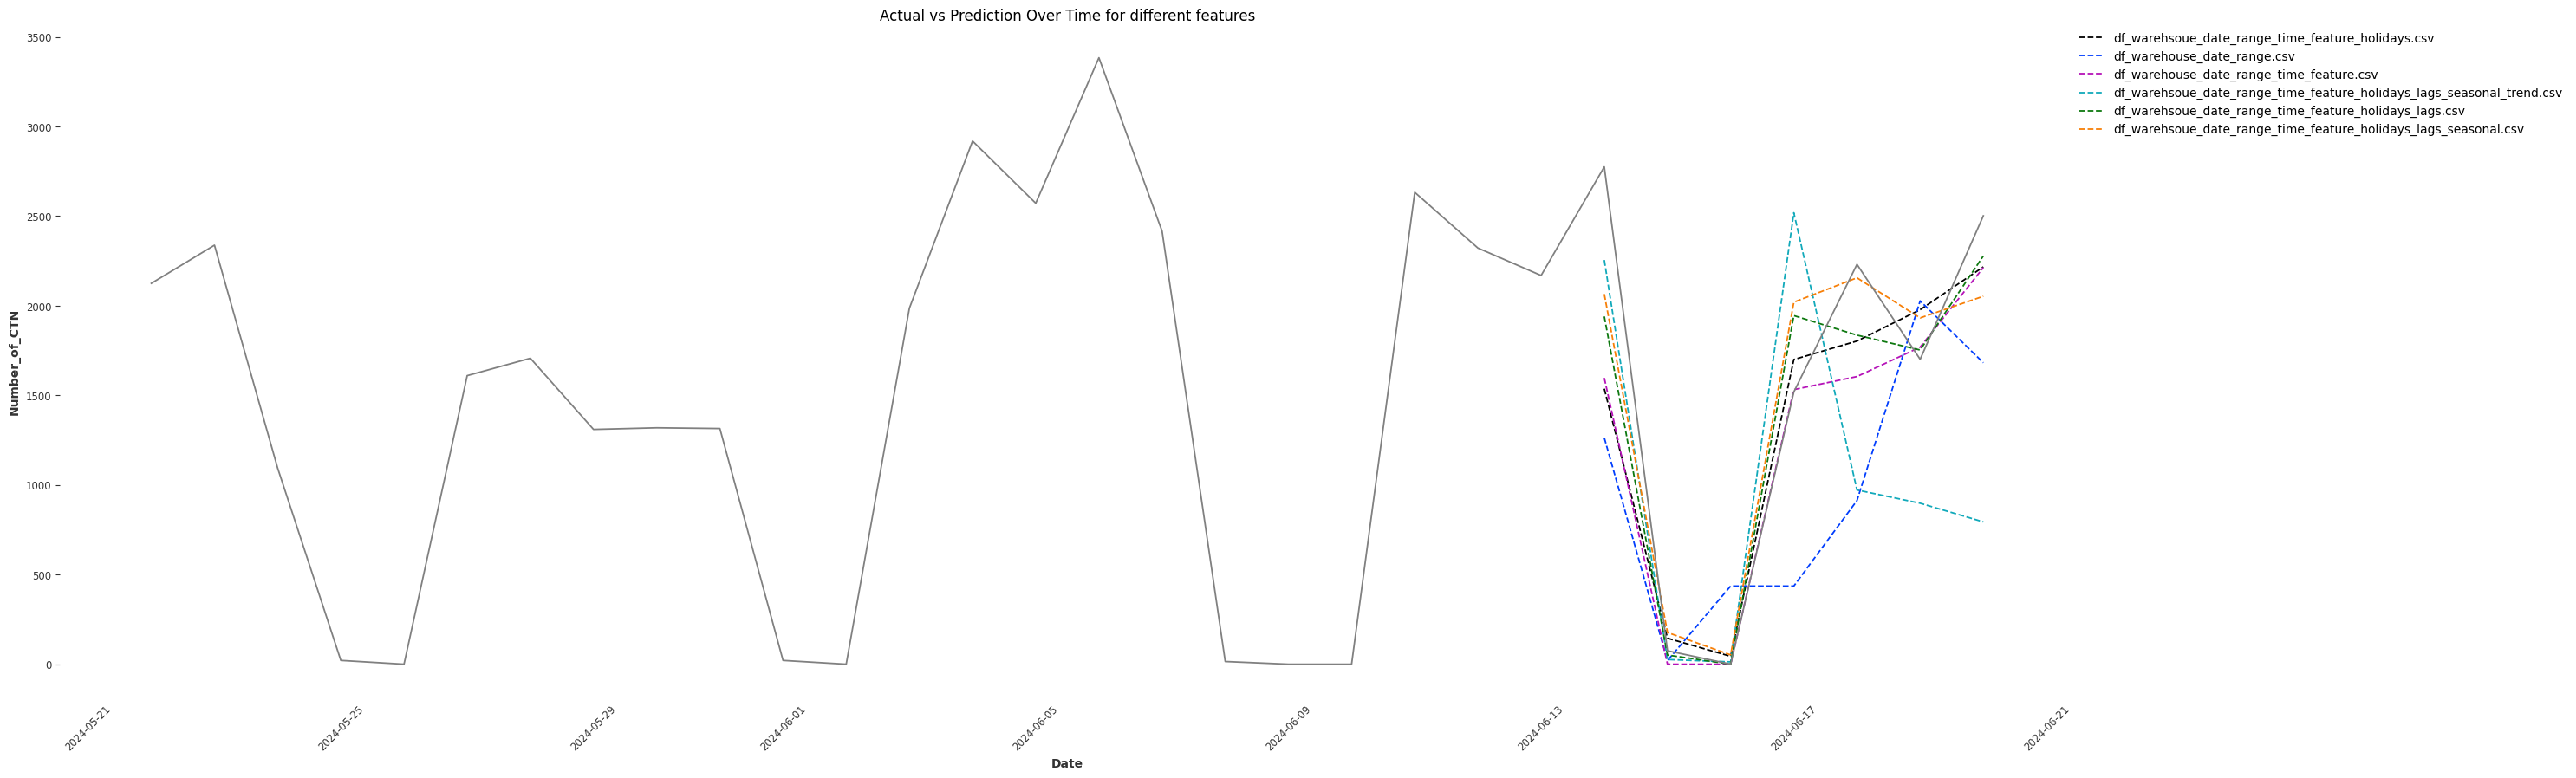

In [280]:
df_warehouse_date_range['df_ML'] = 'df_warehouse_date_range'
df_warehouse_date_range.rename(columns={'# of CTN':'Actual'}, inplace=True)


# define the mumber of testing days and trainig days
df_test_size = 7 #number_of_testing_days

# define the date range of df_train
df_warehouse_date_range_train = df_warehouse_date_range.iloc[:df_train_size]

# limit the date range of efine the date range of df_train to last 30 days
df_warehouse_date_range_train = df_warehouse_date_range.iloc[-30:]

# merge the df_warehouse_date_range_train and predictions
df_full_date_range_prediction = pd.concat([df_warehouse_date_range_train,combined_predictions],ignore_index=True)
df_full_date_range_prediction
print(df_warehouse_date_range.head())


plt.figure(figsize=(30, 10))

for df in df_ML:
  x = combined_predictions[combined_predictions['df_ML'] == df]['date']
  y = combined_predictions[combined_predictions['df_ML'] == df]['Prediction']

  plt.plot(x,y,linestyle='--', label=f'{df}')

x_full_date_range = df_full_date_range_prediction[df_full_date_range_prediction['df_ML'] == 'df_warehouse_date_range']['date']
y_actual = df_full_date_range_prediction[df_full_date_range_prediction['df_ML'] == 'df_warehouse_date_range']['Actual']

plt.plot(x_full_date_range,y_actual, color='grey')



plt.title('Actual vs Prediction Over Time for different features')
plt.xlabel('Date')
plt.ylabel('Number_of_CTN')
plt.xticks(rotation=45)

# Place the legend outside the plot on the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)

plt.grid()